In [1]:
from saifooler.data_modules.multiple_viewpoints_module import MultipleViewModule
from saifooler.render.mesh_descriptor import MeshDescriptor
from saifooler.render.render_module import RenderModule
from saifooler.attacks.pgd_attack import PGDAttack
from saifooler.data_modules.orientation_data_module import OrientationDataModule
from saifooler.classifiers.image_net_classifier import ImageNetClassifier
from saifooler.render.sailenv_module import SailenvModule


import torchvision.transforms.functional as TF
from PIL import Image
import torch
import torchvision

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 



In [10]:
meshes = [
    ('candle', 0.2, 10, 30), 
    ('ewer', 0.3, 10, 30), 
    ('lamp_floor', 0.75, 10, 30), 
    ('plunger', 0.55, 10, 30), 
    ('pot', 0.4, 45, 30), 
    ('remote_controller', 0.2, 75, 30), 
    ('table_living_room', 2.0, 10, 50), 
    ('tennis_racket', 0.6, 70, 5), 
    ('toilet', 1.2, 10, 190), 
    ('toilet_paper', 0.2, 10, 30)
    ]

meshes_path = "./meshes"

background = torch.ones((224,224,3))  # white background

torch.Size([3, 228, 2262])


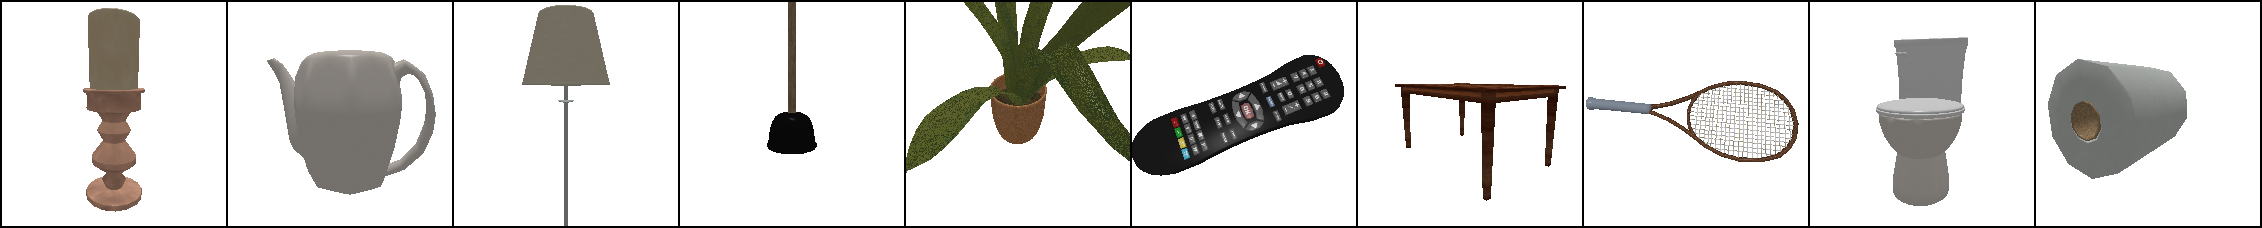

In [11]:
render_module = RenderModule(background=background)
elev = 10
azim = 30

images = []

for mesh_name, distance, elev, azim in meshes[:]:
    mesh_path = os.path.join(meshes_path, mesh_name)
    mesh_descriptor = MeshDescriptor(mesh_path)
    mesh_descriptor.mesh = mesh_descriptor.mesh.to(render_module.device)
    mesh_descriptor.mesh.textures = mesh_descriptor.mesh.textures.to(render_module.device)

    render_module.look_at_mesh(distance, azim, elev)
    img = render_module.render(mesh_descriptor.mesh).squeeze(0).permute((2,0,1))
    images.append(img)

grid = torchvision.utils.make_grid(images, nrow=len(meshes), scale_each=True)

print(grid.shape)

grid = TF.to_pil_image(grid)
grid

grid.save("./test/p3d_grid.png")
grid



In [7]:
from time import sleep
from sailenv.agent import Agent
# optional show in SAILenv
host = "localhost"
port = 8085
agent = Agent(depth_frame_active=False,
                flow_frame_active=False,
                object_frame_active=False,
                main_frame_active=True,
                category_frame_active=False,
                width=224, height=224, host=host,
                port=port, use_gzip=False)
agent.register()

# put white background on unity scene
agent.change_main_camera_clear_flags(0, 0, 0)
agent.change_scene("object_view/scene")
sleep(10)

sailenv_module = SailenvModule(agent, render_module.lights, background=background)

images = []

for mesh_name, distance, elev, azim in meshes[:]:
    elev = torch.tensor(elev)
    azim = torch.tensor(azim)
    mesh_path = os.path.join(meshes_path, mesh_name)
    mesh_descriptor = MeshDescriptor(mesh_path)
    mesh_descriptor.mesh = mesh_descriptor.mesh.to(render_module.device)
    mesh_descriptor.mesh.textures = mesh_descriptor.mesh.textures.to(render_module.device)

    sailenv_module.spawn_obj(mesh_descriptor)
    sailenv_module.look_at_mesh(distance, azim, elev)
    sleep(2)
    img = sailenv_module.render(mesh_descriptor.mesh).squeeze(0).permute((2,0,1))
    images.append(img)
    sailenv_module.despawn_obj()

grid = torchvision.utils.make_grid(images, nrow=len(meshes), scale_each=True)

print(grid.shape)

grid = TF.to_pil_image(grid)
grid


KeyboardInterrupt: 